In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils import utils, torch_utils

from config import init_args
import data
import models
import librosa
import copy

import json
from moviepy.editor import VideoFileClip
import argparse
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, auc

In [2]:
SAMPLE_RATE = 22050
FRAME_RATE = 15
DURATION = 10

def onset_nms(onset, confidence, window=0.1):
    window = librosa.time_to_samples(window, sr=FRAME_RATE)
    
    if window < 1:
        return onset
    
    # Non-Maximum Suppression, NMS
    # : descard the duplicated onset
    onset_remain = onset.tolist()
    output = []
    # descending order of confidence of predicted onset
    sorted_idx = np.argsort(confidence)[::-1]   
    
    for idx in sorted_idx:
        cur = onset[idx]
        if cur not in onset_remain:
            continue
        output.append(cur)
        onset_remain.remove(cur)
        for o in onset_remain:
            if abs(cur - o) < window:
                onset_remain.remove(o)
    return np.array(sorted(output))


def eval_onsets(onset_gt, onset_pred, logits, delta=0.1, conf_interval=0.05, keys=None): 
    # delta 0.05 conf_interval 0.05, delta 0.05 conf_interval 0.025
    # conf_interval: 0.05sec (0 frame), 0.1sec (1 frame)
    
    conf_interval = librosa.time_to_samples(conf_interval, sr=FRAME_RATE)        
    logits = np.abs(logits)                                                     
    logits = (logits - np.min(logits)) / (np.max(logits) - np.min(logits))
    
    if len(logits) < DURATION * FRAME_RATE:
        print("logits len: ", len(logits))
        print("logits is too short")
        
    # onset_pred : frame numbers of predicted onsets
    # confidence : the highest probability in the predicred onset frame
    # print("Confidence interval: ", conf_interval)
    
    if conf_interval > 0:
        confidence = [np.max(logits[max(0, o-conf_interval):min(len(logits)-1, o+conf_interval)]) for o in onset_pred if len(logits) > 0]
    else:
        confidence = [np.max(logits[o]) for o in onset_pred if len(logits) > 0]
    
    # OnsetNMS
    onset_pred = onset_nms(onset_pred, confidence)
    onset_pred_keep = onset_pred
    onset_pred_onuse = copy.deepcopy(onset_pred.tolist())       
    onset_pred_res = [0 for _ in onset_pred_onuse]
    
    hit_cnt = 0
    y_gt = []
    y_pred = []
    
    delta = librosa.time_to_samples(delta, sr=FRAME_RATE)   # 0.1 sec, 1 frame

    for o in onset_gt:
        # frame level difference between onset_gt and onset_pred
        diff = [abs(o2 - o) for o2 in onset_pred_onuse]
        # indices of onset_pred in the window
        idx_in_window = [idx for idx in range(len(onset_pred_onuse)) if diff[idx] < delta]  
        
        if len(idx_in_window) == 0:
            y_gt.append(1)
            y_pred.append(0)
        else:
            # confidence of predicted onset in the window
            conf_in_window = [logits[onset_pred_onuse[idx]] for idx in idx_in_window]  
             # the highest confidence index in the window 
            max_conf_idx = np.argsort(conf_in_window)[-1]                              
            match_idx = idx_in_window[max_conf_idx]                                     
            hit_cnt += 1
            y_gt.append(1)
            
            if conf_interval > 0:
                conf = np.max(logits[max(0, onset_pred_onuse[match_idx]-conf_interval):min(len(logits)-1, onset_pred_onuse[match_idx]+conf_interval)])
            else:
                conf = np.max(logits[onset_pred_onuse[match_idx]])
                
            for i in range(len(onset_pred_keep)):
                if onset_pred_keep[i] == onset_pred_onuse[match_idx]:
                    onset_pred_res[i] = 1
            y_pred.append(conf)
            onset_pred_onuse.remove(onset_pred_onuse[match_idx])     
            if len(onset_pred_onuse) == 0:
                break

    for o in onset_pred_onuse:
        y_gt.append(0)
        if conf_interval > 0:
            y_pred.append(np.max(logits[max(0, o-conf_interval):min(len(logits)-1, o+conf_interval)]))
        else:
            y_pred.append(np.max(logits[o]))
            
    y_pred_binarized = [1 if y >= 0.5 else 0 for y in y_pred]
    
    # ACC calculation A
    # TP = sum([1 for i in range(len(y_gt)) if y_gt[i] == 1 and y_pred_binarized[i] == 1])
    # TN = sum([1 for i in range(len(y_gt)) if y_gt[i] == 0 and y_pred_binarized[i] == 0])
    # FP = sum([1 for i in range(len(y_gt)) if y_gt[i] == 0 and y_pred_binarized[i] == 1])
    # FN = sum([1 for i in range(len(y_gt)) if y_gt[i] == 1 and y_pred_binarized[i] == 0])
    # acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    
    # ACC calculation B
    acc = accuracy_score(y_gt, y_pred_binarized)
    ap = average_precision_score(y_gt, y_pred)
    pr, rc, th = precision_recall_curve(y_gt, y_pred)
    
    if keys != None and args.plt:
        plt.plot(rc, pr)
        plt.ylim((0, 1))
        plt.savefig(f'tmp/pc_rc_curve_tar_{keys[0]}_cond_{keys[1]}.jpg')
        plt.close()

    return acc, ap, onset_pred_res, y_gt, y_pred

Removed samples (less than 150.0 frames) : 0
Greatesthit Dataloader: # sample of test: 4041
Number of parameters in the model: 31365918
=> loading checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar'
=> loaded checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar' (epoch 100)
Test Set 0 - Accuracy: 0.29, AP: 0.84
Test Set 1 - Accuracy: 0.33, AP: 0.81
Test Set 2 - Accuracy: 0.39, AP: 0.83
Test Set 3 - Accuracy: 0.42, AP: 0.82
Test Set 4 - Accuracy: 0.44, AP: 0.84
Test Set 5 - Accuracy: 0.44, AP: 0.88
Test Set 6 - Accuracy: 0.50, AP: 0.81
Test Set 7 - Accuracy: 0.33, AP: 0.81
Test Set 8 - Accuracy: 0.47, AP: 0.84
Test Set 9 - Accuracy: 0.57, AP: 0.76
Test Set 10 - Accuracy: 0.45, AP: 0.72
Test Set 11 - Accuracy: 0.47, AP: 0.74
Test Set 12 - Accuracy: 0.48, AP: 0.67
Test Set 13 - Accuracy: 0.36, AP: 0.56
Test Set 14 - Accuracy: 0.47, AP: 0.68
Test Set 15 

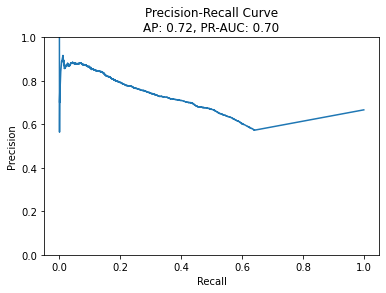

In [4]:
# Model checkpoint 2sec / 100epochs
# checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_2sec/checkpoint_ep100.pth.tar'
# Model checkpoint 10sec / 100epochs
checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar'
# Model checkpoint 2sec / 100epochs, weight decay & batch size adjusted
# checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_2sec/checkpoint_ep100.pth.tar'

args = init_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_rate = SAMPLE_RATE
frame_rate = FRAME_RATE
duration = DURATION

test_dataset = data.GreatestHitDataset(args, split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

net = models.VideoOnsetNet(pretrained=False).to(device)
num_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters in the model: {num_params}")

# load the trained model weights
net, _ = torch_utils.load_model(checkpoint_path, net, device=device, strict=True)
net.eval()

all_y_gt = []
all_y_pred = []
all_acc = []

for step, batch in enumerate(test_loader):
    inputs = {'frames': batch['frames'].to(device)}
    
    with torch.no_grad():
        pred = net(inputs)
    
    # ground truth onsets
    target = batch['label'].to(device)
    target_np = target.cpu().numpy()
    pred_np = pred.cpu().numpy() 
    
    # sigmoid to pred_np
    logits = pred_np[0]                                      # min -inf, max inf
    pred_prob = 1 / (1 + np.exp(-pred_np))                   # sigmoid : min 0, max 1
    pred_np = np.where(pred_prob > 0.5, 1.0, 0.0)            # binary : min 0, max 1

    target_frames = np.where(target_np[0] == 1)[0] 
    pred_frames = np.where(pred_np[0] == 1)[0]
    
    onset_gt = target_frames            # gt (min 0, max 149, len: num of gt onsets) (15fps, 10sec)
    onset_pred = pred_frames            # pred (min 0, max 149, len: num of pred onsets) (15fps, 10sec)
    
    acc, ap, onset_pred_res, y_gt, y_pred = eval_onsets(onset_gt, onset_pred, logits) 
    # print(f"Test Set {step} - Accuracy: {acc:.2f}, AP: {ap:.2f}")
    
    all_y_gt.extend(y_gt)
    all_y_pred.extend(y_pred)
    all_acc.append(acc)
    
overall_acc = np.mean(all_acc)
overall_ap = average_precision_score(all_y_gt, all_y_pred)
pr, rc, th = precision_recall_curve(all_y_gt, all_y_pred)
pr_auc = auc(rc, pr)

print(f"Overall Test Set - Accuracy: {overall_acc:.2f}, AP: {overall_ap:.2f}")

plt.plot(rc, pr)
plt.title(f'Precision-Recall Curve\nAP: {overall_ap:.2f}, PR-AUC: {pr_auc:.2f}')
plt.ylim((0, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# A. 2 sec, without Confidence Interval and Onset NMS
# A-1. accuracy_score in sklearn.metrics 
# Overall Test Set - Accuracy: 0.50, AP: 0.70

# A. 10 sec, without Confidence Interval and Onset NMS
# A-1. accuracy_score in sklearn.metrics 
# Number of parameters in the model: 31365918
# Overall Test Set - Accuracy: 0.47, AP: 0.72, PR-AUC: 0.70

# SyncFusion
# Accuracy: 0.49.39, AP: 0.88.83

Removed samples (less than 150.0 frames) : 0
Greatesthit Dataloader: # sample of test: 4041
=> loading checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar'
=> loaded checkpoint '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar' (epoch 100)


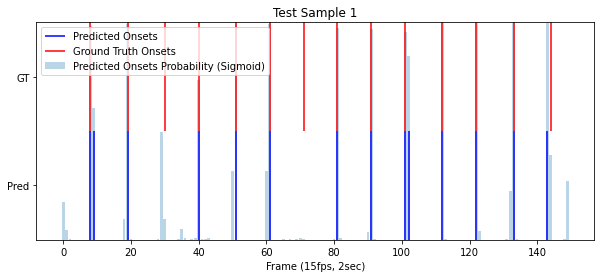

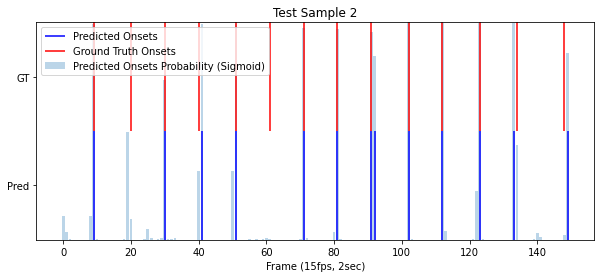

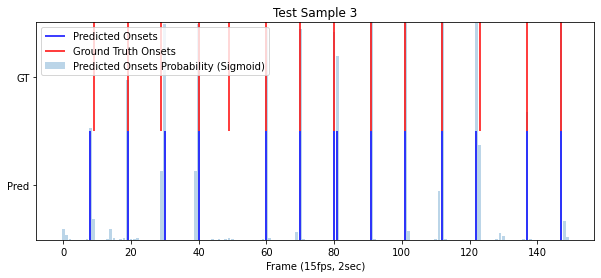

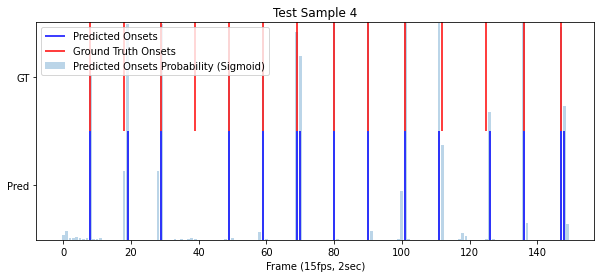

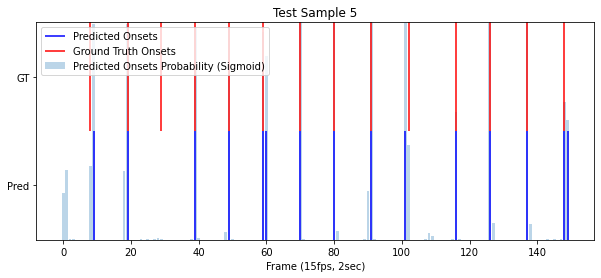

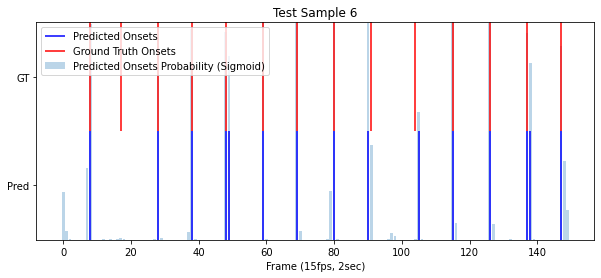

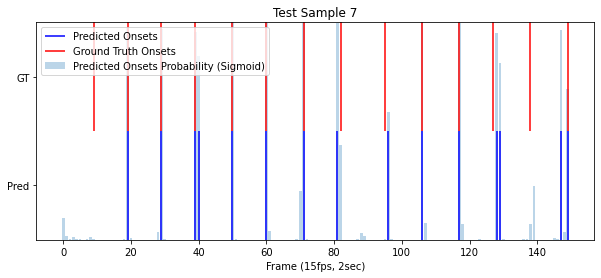

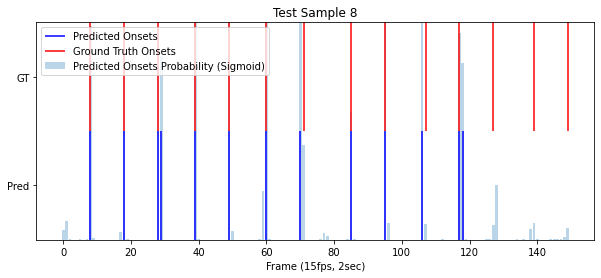

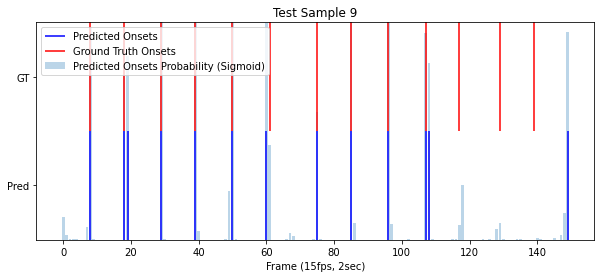

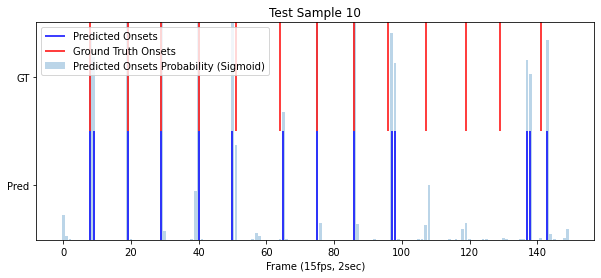

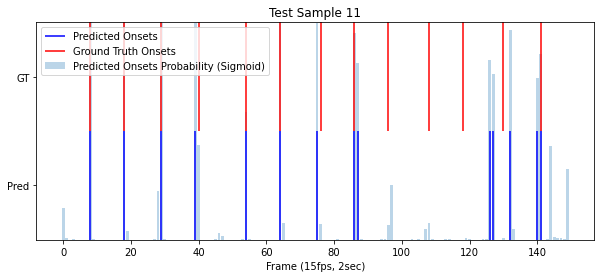

In [5]:
# Model checkpoint 2sec / 100epochs
# checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_2sec/checkpoint_ep100.pth.tar'
# Model checkpoint 10sec / 100epochs
checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_10sec/checkpoint_ep100.pth.tar'
# Model checkpoint 2sec / 100epochs, weight decay & batch size adjusted
# checkpoint_path = '/home/dabin/video2foley/CondFoleyGen/specvqgan/onset_baseline/checkpoints/EXP_2sec/checkpoint_ep100.pth.tar'

args = init_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = data.GreatestHitDataset(args, split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=1,   # args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

net = models.VideoOnsetNet(pretrained=False).to(device)

# Load the trained model weights
net, _ = torch_utils.load_model(checkpoint_path, net, device=device, strict=True)
net.eval()

all_y_gt = []
all_y_pred = []
all_acc = []

for step, batch in enumerate(test_loader):
    inputs = {
        'frames': batch['frames'].to(device)
    }
    
    with torch.no_grad():
        pred = net(inputs)
    
    # Ground truth onsets
    target = batch['label'].to(device)
    target_np = target.cpu().numpy()
    pred_np = pred.cpu().numpy()
    
    logits = pred_np[0]
    
    # Sigmoid to pred_np
    pred_prob = 1 / (1 + np.exp(-pred_np))
    pred_np = np.where(pred_prob > 0.5, 1.0, 0.0)

    
    plt.figure(figsize=(10, 4)) 
    
    # Predicted onsets (Sigmoid)
    plt.bar(range(len(pred_prob[0])), pred_prob[0], alpha=0.3, label='Predicted Onsets Probability (Sigmoid)')
    
    # Predicted onsets
    pred_np = np.where(pred_np[0] == 1)[0]
    plt.vlines(pred_np, 0.0, 0.5, colors='b', linestyles='solid', label='Predicted Onsets')

    # Ground truth onsets
    target_np = np.where(target_np[0] == 1)[0]
    plt.vlines(target_np, 0.5, 1.0, colors='r', linestyles='solid', label='Ground Truth Onsets')
    
    plt.ylim(0, 1)
    plt.yticks([0.25, 0.75], ['Pred', 'GT'])
    plt.xlabel('Frame (15fps, 2sec)')
    plt.legend(loc='upper left')
    plt.title(f'Test Sample {step+1}')
    plt.show()
    
    if step >= 10:
        break

In [6]:
import json
import glob
import soundfile as sf
import IPython.display as ipd


index = 0

list_sample = '/home/dabin/video2sound/CondFoleyGen/data/greatesthit_test_2.00.json'
with open(list_sample, "r") as f:
    list_sample = json.load(f)
if args.max_sample > 0:
    list_sample = list_sample[:args.max_sample]

info = list_sample[index].split('_')[0]
video_path = os.path.join('/home/dabin/video2sound/CondFoleyGen/data', 'greatesthit', 'greatesthit-process-resized', info)
frame_path = os.path.join(video_path, 'frames')
audio_path = os.path.join(video_path, 'audio')
audio_path = glob.glob(f"{audio_path}/*.wav")
audio_path = audio_path[0]
print("Audio path: ", audio_path)

audio, sr = sf.read(audio_path, start=0, stop=1000, dtype='float64', always_2d=True)

# Listen the sample audio in jupyter notebook
ipd.Audio(audio, rate=sr)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dabin/video2sound/CondFoleyGen/data/greatesthit_test_2.00.json'